<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Sample                              212 non-null    int64  
 1   Diagnostic                          212 non-null    object 
 2   Sex                                 212 non-null    object 
 3   Age                                 212 non-null    int64  
 4   MMSE                                212 non-null    int64  
 5   CSF Amyloid (pg/mL)                 198 non-null    float64
 6   CSF Total tau (pg/mL)               198 non-null    float64
 7   CSF Phosphorylated tau (pg/mL)      198 non-null    float64
 8   APOE4                               209 non-null    object 
 9   Progression to Alzheimer's Disease  89 non-null     object 
 10  Progression time (months)           47 non-null     float64
dtypes: float64(4), int64(3), object(4)
memory usa

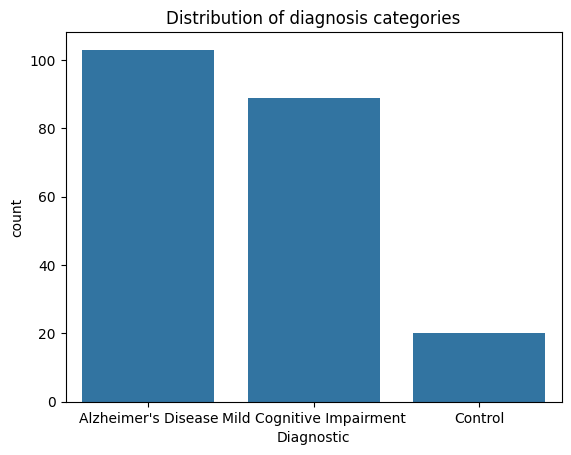

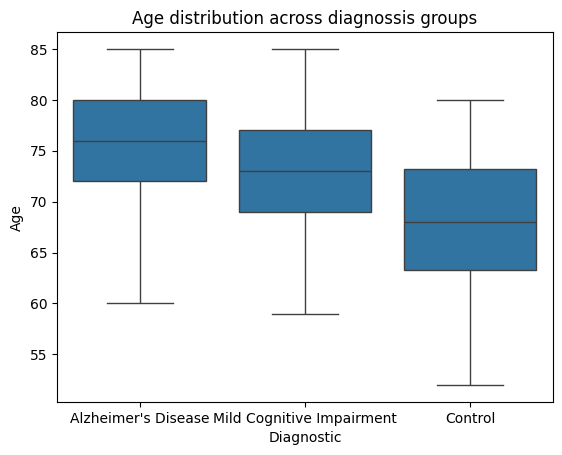

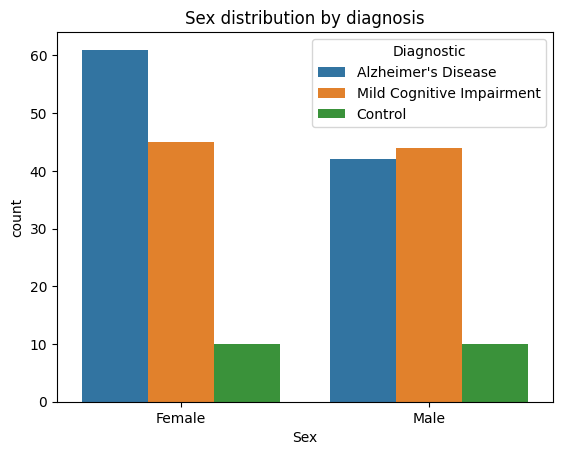

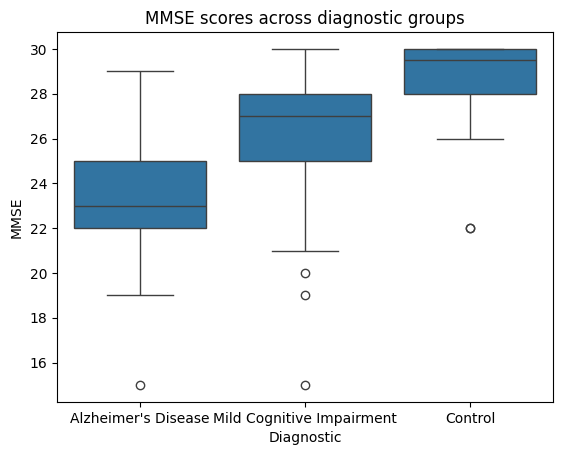

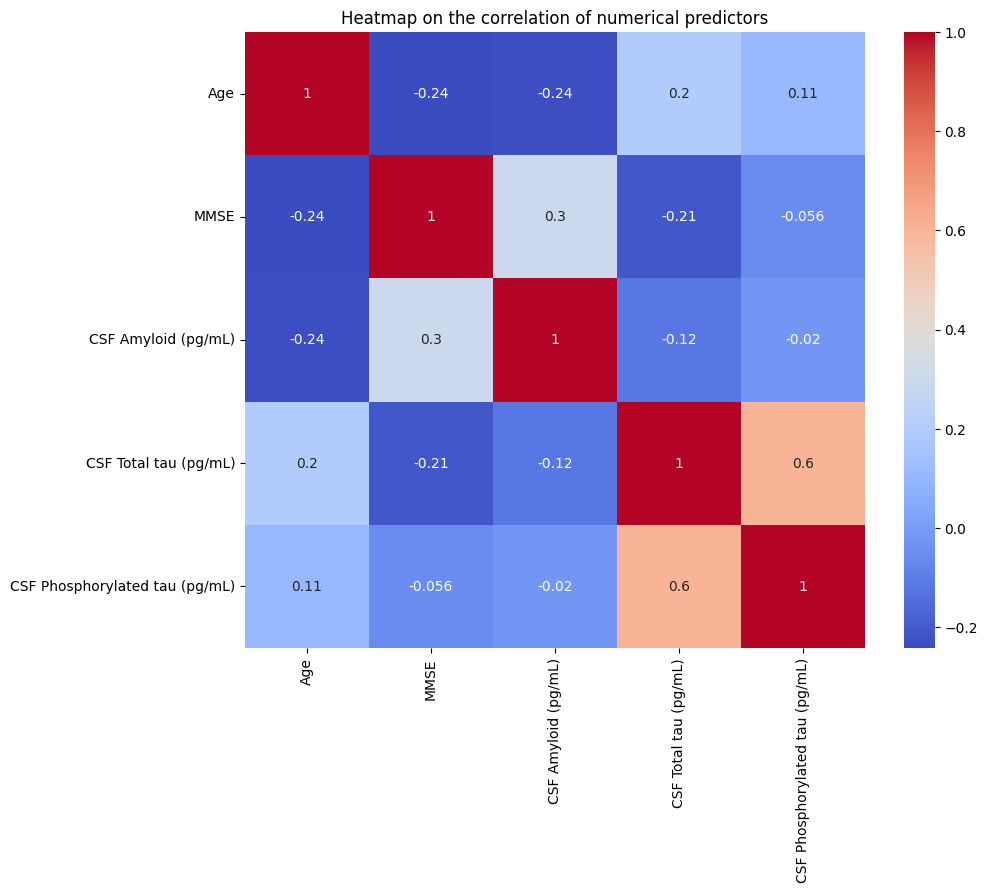

Training set distribution:
AD_binary
0    82
1    77
Name: count, dtype: int64

Test set distribution:
AD_binary
0    27
1    26
Name: count, dtype: int64


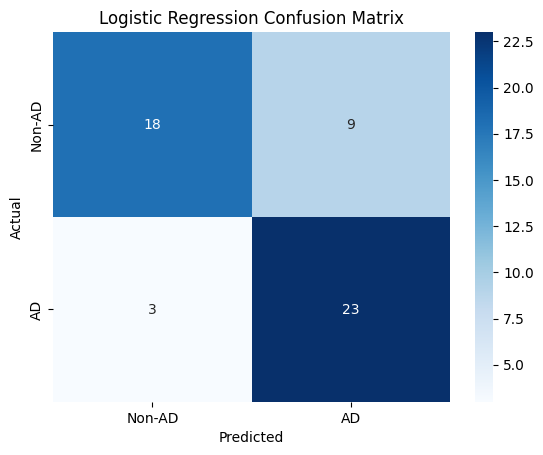

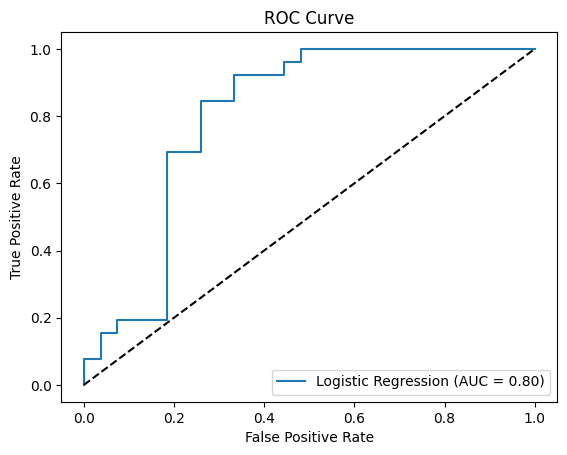

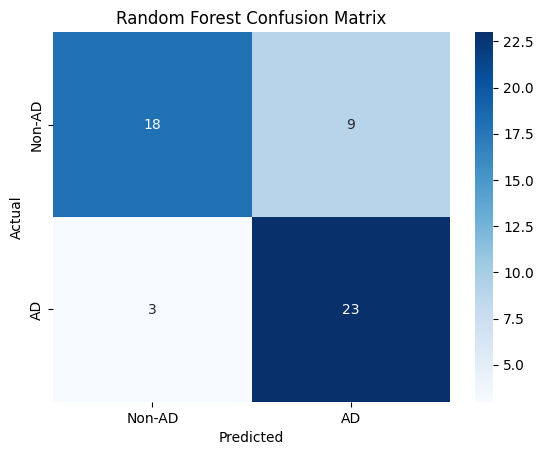

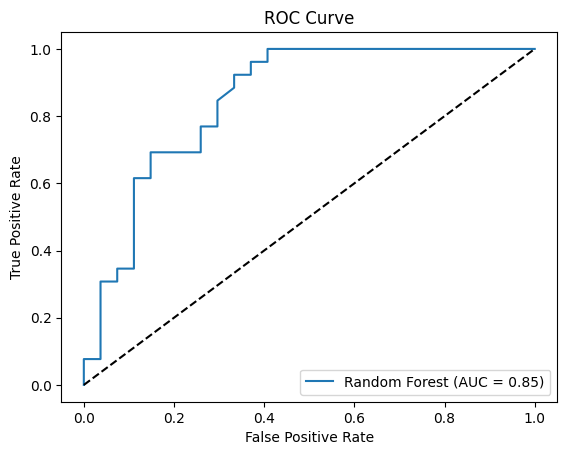


Logistic Regression Accuracy: 0.7735849056603774
Random Forest Accuracy: 0.7735849056603774
Logistic Regression ROC AUC: 0.8005698005698006
Random Forest ROC AUC: 0.8497150997150997


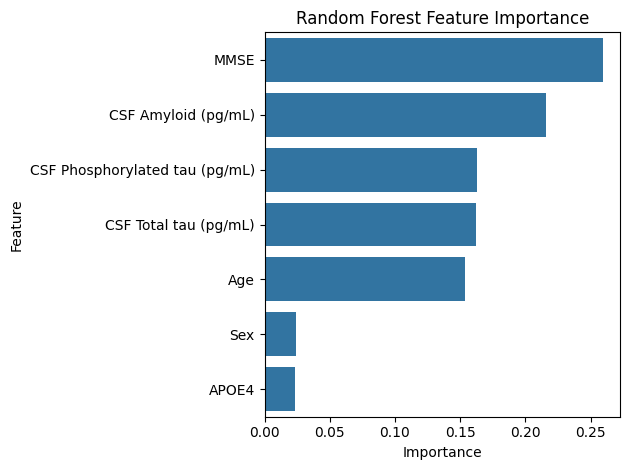

In [7]:
###############################
#### Individual assessment ####
###############################

######## 1. Import packages ###

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

######## 2. Import data #######

#Assign dataset to df.
df = pd.read_csv("plasma_lipidomics_AD.csv")

######## 3. Explore data ######

df.info()
df.head()

#explore distribution of classes in diagnosis
sns.countplot(x="Diagnostic", data=df)
plt.title("Distribution of diagnosis categories")
plt.show()

#explore correlation between age and diagnosis
sns.boxplot(x="Diagnostic", y="Age", data=df)
plt.title("Age distribution across diagnossis groups")
plt.show()

#explore the effect of sex on diagnosis
sns.countplot(x="Sex", hue="Diagnostic", data=df)
plt.title("Sex distribution by diagnosis")
plt.show()

#explore MMSE variable (cognitive score) 
sns.boxplot(x="Diagnostic", y="MMSE", data=df)
plt.title("MMSE scores across diagnostic groups")
plt.show()

#how many nulls do we have
df[[
    "CSF Amyloid (pg/mL)",
    "CSF Total tau (pg/mL)",
    "CSF Phosphorylated tau (pg/mL)"
]].isnull().sum()

#explore correlations between predictors
num_features = [
    "Age",
    "MMSE",
    "CSF Amyloid (pg/mL)",
    "CSF Total tau (pg/mL)",
    "CSF Phosphorylated tau (pg/mL)"
]

plt.figure(figsize=(10,8))
sns.heatmap(df[num_features].corr(), annot=True, cmap="coolwarm")
plt.title("Heatmap on the correlation of numerical predictors")
plt.show()

######## 4. Pre-processing data #

#change sex and APOE to binary
df["Sex"] = LabelEncoder().fit_transform(df["Sex"])
df["APOE4"] = LabelEncoder().fit_transform(df["APOE4"])

#create a new column AD_binary which is the binarised version of diagnosis
df["AD_binary"] = (df["Diagnostic"] == "Alzheimer's Disease").astype(int)

######## 5.  Train and test model on data #

# Define features and dependent variable
features = [
    "Age", "Sex", "MMSE",
    "CSF Amyloid (pg/mL)",
    "CSF Total tau (pg/mL)",
    "CSF Phosphorylated tau (pg/mL)",
    "APOE4"
]

X = df[features]
y = df["AD_binary"]

#Train–test split (75%train:25%test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

#verify split
print("Training set distribution:")
print(y_train.value_counts())
print("\nTest set distribution:")
print(y_test.value_counts())

#Logistic Regression
logreg_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

#Train model
logreg_pipeline.fit(X_train, y_train)

# Predictions
y_pred_lr = logreg_pipeline.predict(X_test)
y_prob_lr = logreg_pipeline.predict_proba(X_test)[:, 1]

#Confusion matrix plot
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-AD", "AD"], yticklabels=["Non-AD", "AD"])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#Random Forest

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced")

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

#Confusion matrix plot
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-AD", "AD"], yticklabels=["Non-AD", "AD"])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#Print model scores for comparison
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Logistic Regression ROC AUC:", roc_auc_lr)
print("Random Forest ROC AUC:", roc_auc_rf)

#Random Forest feature importance bar chart
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

sns.barplot(
    x="Importance",
    y="Feature",
    data=importances
)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()
